In [1]:
import sys, os, json
from collections import deque
from typing import Sequence, Tuple, List
sys.path.append(os.getcwd())  # 确保能导入当前目录下的模块
from polygon_generate_suite import load_polys_cases, generate_ploys
from viz_suite import render_ploys, render_hulls
from melkman_analysis import analyze_melkman_complexity

In [2]:
Point = Tuple[int, int]

def melkman_convex_hull(polygon: Sequence[Point], verbose: bool = True) -> List[Point]:
    # ---------- helpers ----------
    def cross(ax, ay, bx, by): return ax*by - ay*bx
    def orient(a, b, c): return cross(b[0]-a[0], b[1]-a[1], c[0]-a[0], c[1]-a[1])
    def is_left(a, b, c): return orient(a, b, c) > 0            # 严格左侧
    def is_right_or_on(a, b, c): return orient(a, b, c) <= 0    # 右侧或共线
    def fmtD(D: deque) -> str:
        return "[" + " | ".join(f"{i}:{p}" for i, p in enumerate(D)) + "]"
    def log(*args):
        if verbose: print(*args)

    # ---------- preprocess: 相邻去重 + 去掉重复首点 ----------
    pts: List[Point] = []
    for p in polygon:
        if not pts or p != pts[-1]:
            pts.append(p)
    if len(pts) >= 2 and pts[0] == pts[-1]:
        pts.pop()

    n = len(pts)
    log(f"[init] n={n}")
    log(f"[init] pts={pts}")
    if n == 0: log("[early-exit] empty"); return []
    if n == 1: log("[early-exit] single"); return [pts[0]]
    if n == 2: log("[early-exit] two");    return [pts[0], pts[1]]

    # ---------- 修正点：展开共线前缀，p1 指向前缀最后一个点 ----------
    p0 = pts[0]
    i1 = 1
    while i1 + 1 < n and orient(p0, pts[i1], pts[i1 + 1]) == 0:
        log(f"[collinear-prefix-extend] ({p0}) -> ({pts[i1]}) -> ({pts[i1+1]}) collinear; advance i1")
        i1 += 1
    p1 = pts[i1]
    log(f"[seed-edge] p0={p0}, p1={p1}  (seed base uses last collinear endpoint)")

    # 找首个非共线的第三点 p2（相对 p0,p1）
    k = i1 + 1
    while k < n and orient(p0, p1, pts[k]) == 0:
        log(f"[seek-p2] k={k} {pts[k]} still collinear with seed edge")
        k += 1
    if k == n:
        lo = min(pts); hi = max(pts)
        hull = [lo, hi] if lo != hi else [lo]
        log("[all-collinear] hull=", hull)
        return hull
    p2 = pts[k]
    o = orient(p0, p1, p2)
    log(f"[seed-triple] p2={p2}, orient={o} -> {'CCW' if o>0 else 'CW'}")

    # ---------- 初始化 D：使 P0,P1,P2 在 D 中为 CCW，且 P2 同时在 top/bot ----------
    D = deque()
    if o > 0:
        D.append(p2); D.append(p0); D.append(p1); D.append(p2)
        log("[D-init-CCW] D=", fmtD(D))
    else:
        D.append(p2); D.append(p1); D.append(p0); D.append(p2)
        log("[D-init-CW->fix] D=", fmtD(D))

    # ---------- 扫描 i = k+1..n-1（按原序，不环回） ----------
    for i in range(k + 1, n):
        p = pts[i]
        log(f"\n[scan] i={i}, p={p}")
        in_top = is_left(D[-2], D[-1], p)
        in_bot = is_left(D[0], D[1], p)
        log(f"[inside-test] left(top {D[-2]}->{D[-1]})={in_top}, left(bot {D[0]}->{D[1]})={in_bot}")
        if in_top and in_bot:
            log("[action] inside -> skip")
            continue

        # 底部调整
        while is_right_or_on(D[0], D[1], p):
            removed = D.popleft()
            log(f"[pop-bot] removed={removed}; D={fmtD(D)}")
        D.appendleft(p)
        log(f"[push-bot] insert {p}; D={fmtD(D)}")

        # 顶部调整
        while is_right_or_on(D[-2], D[-1], p):
            removed = D.pop()
            log(f"[pop-top] removed={removed}; D={fmtD(D)}")
        D.append(p)
        log(f"[push-top] append {p}; D={fmtD(D)}")

    # ---------- 收尾 ----------
    dup = D.pop()
    log(f"\n[finalize] pop tail duplicate={dup}")
    hull = list(D)
    log("[hull] =", hull)
    return hull

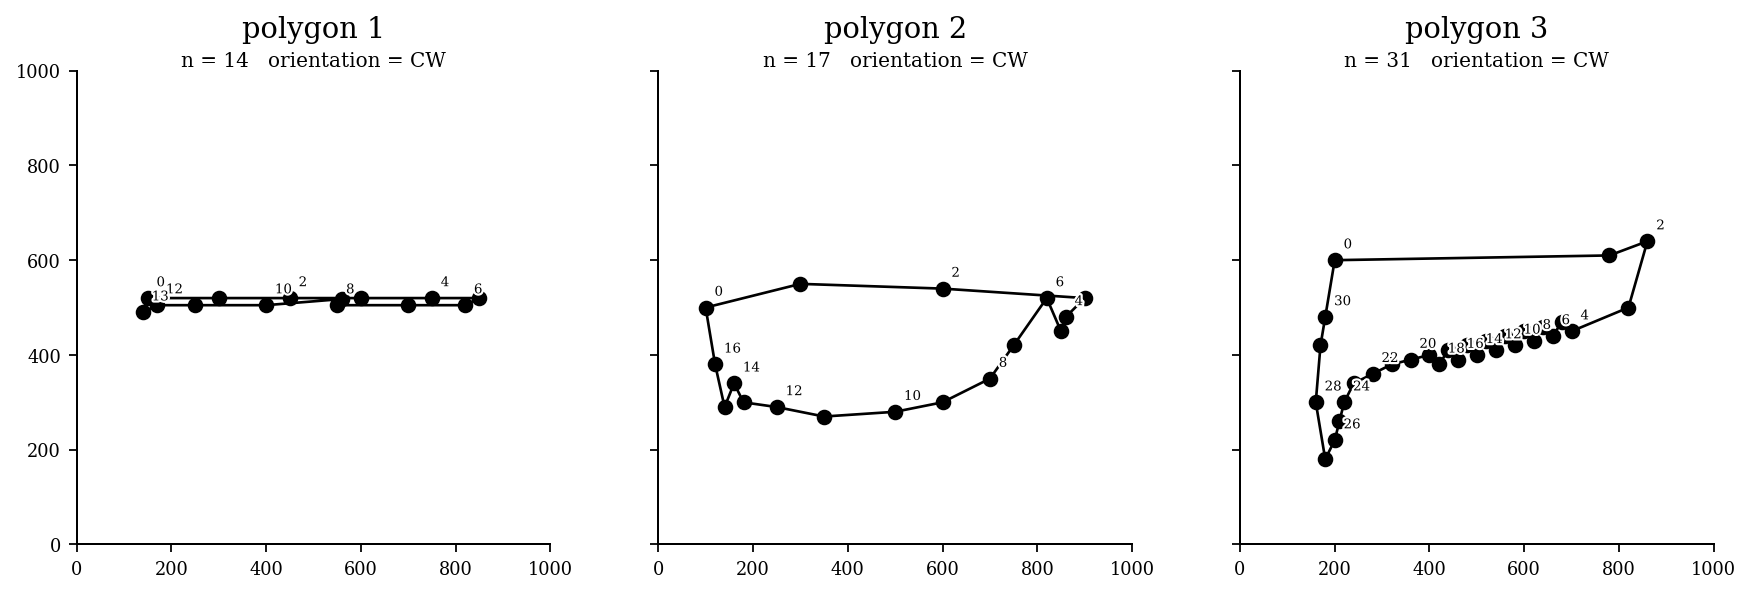

[init] n=14
[init] pts=[(150, 520), (300, 520), (450, 520), (600, 520), (750, 520), (850, 520), (820, 505), (700, 505), (550, 505), (560, 518), (400, 505), (250, 505), (170, 505), (140, 490)]
[collinear-prefix-extend] ((150, 520)) -> ((300, 520)) -> ((450, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((450, 520)) -> ((600, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((600, 520)) -> ((750, 520)) collinear; advance i1
[collinear-prefix-extend] ((150, 520)) -> ((750, 520)) -> ((850, 520)) collinear; advance i1
[seed-edge] p0=(150, 520), p1=(850, 520)  (seed base uses last collinear endpoint)
[seed-triple] p2=(820, 505), orient=-10500 -> CW
[D-init-CW->fix] D= [0:(820, 505) | 1:(850, 520) | 2:(150, 520) | 3:(820, 505)]

[scan] i=7, p=(700, 505)
[inside-test] left(top (150, 520)->(820, 505))=False, left(bot (820, 505)->(850, 520))=True
[push-bot] insert (700, 505); D=[0:(700, 505) | 1:(820, 505) | 2:(850, 520) | 3:(150, 520) | 4:(820, 505)]

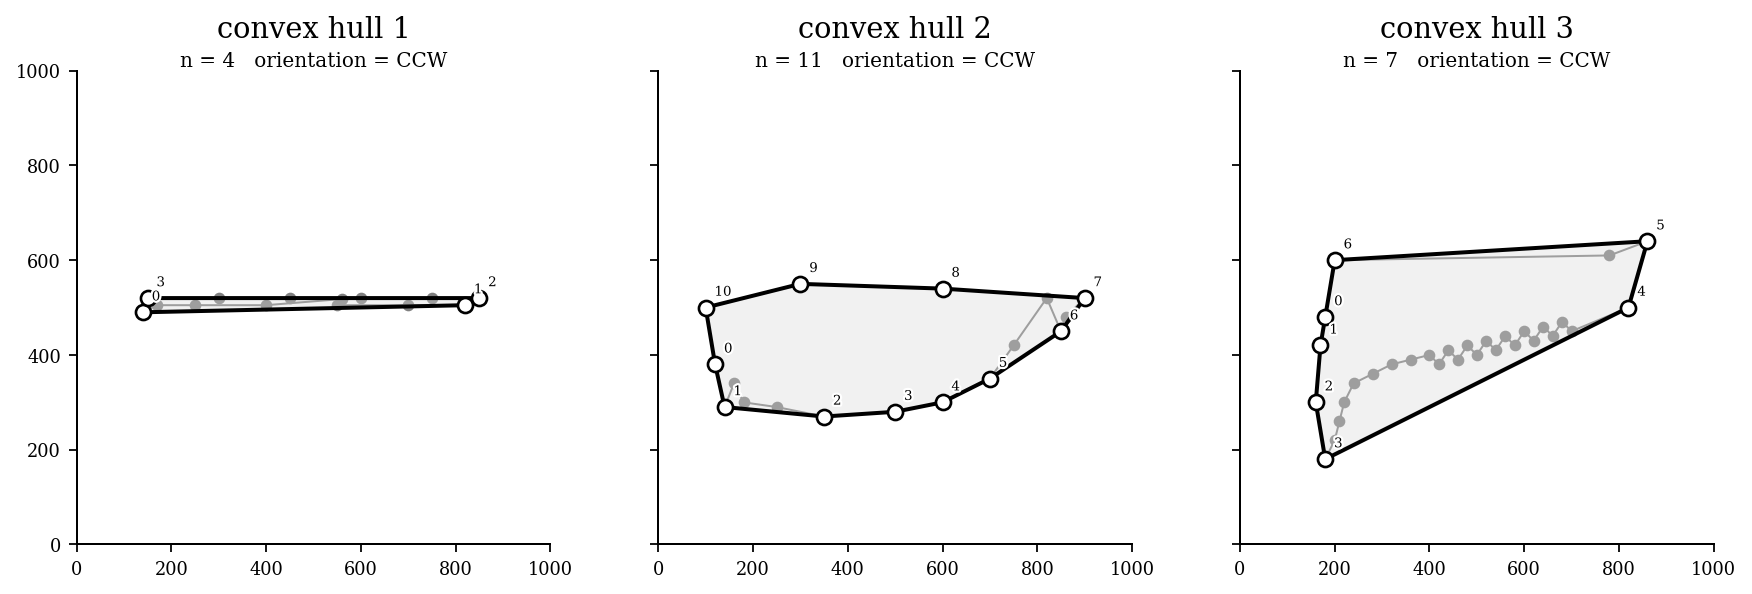

In [3]:
Polys = load_polys_cases()
Poly1, Poly2, Poly3 = Polys[0], Polys[1], Polys[2]

render_ploys(
    ploys = Polys,
    mark_every = 2,
    coord_range = 1000,
    cols_per_row = 3,
)

Hull1 = melkman_convex_hull(Poly1)
Hull2 = melkman_convex_hull(Poly2)
Hull3 = melkman_convex_hull(Poly3)

Hulls = [Hull1, Hull2, Hull3]

render_hulls(
    hulls = Hulls,
    polys = Polys,
    mark_every_poly = 0,
    mark_every_hull= 1,
    coord_range = 1000,
    cols_per_row = 3,
)


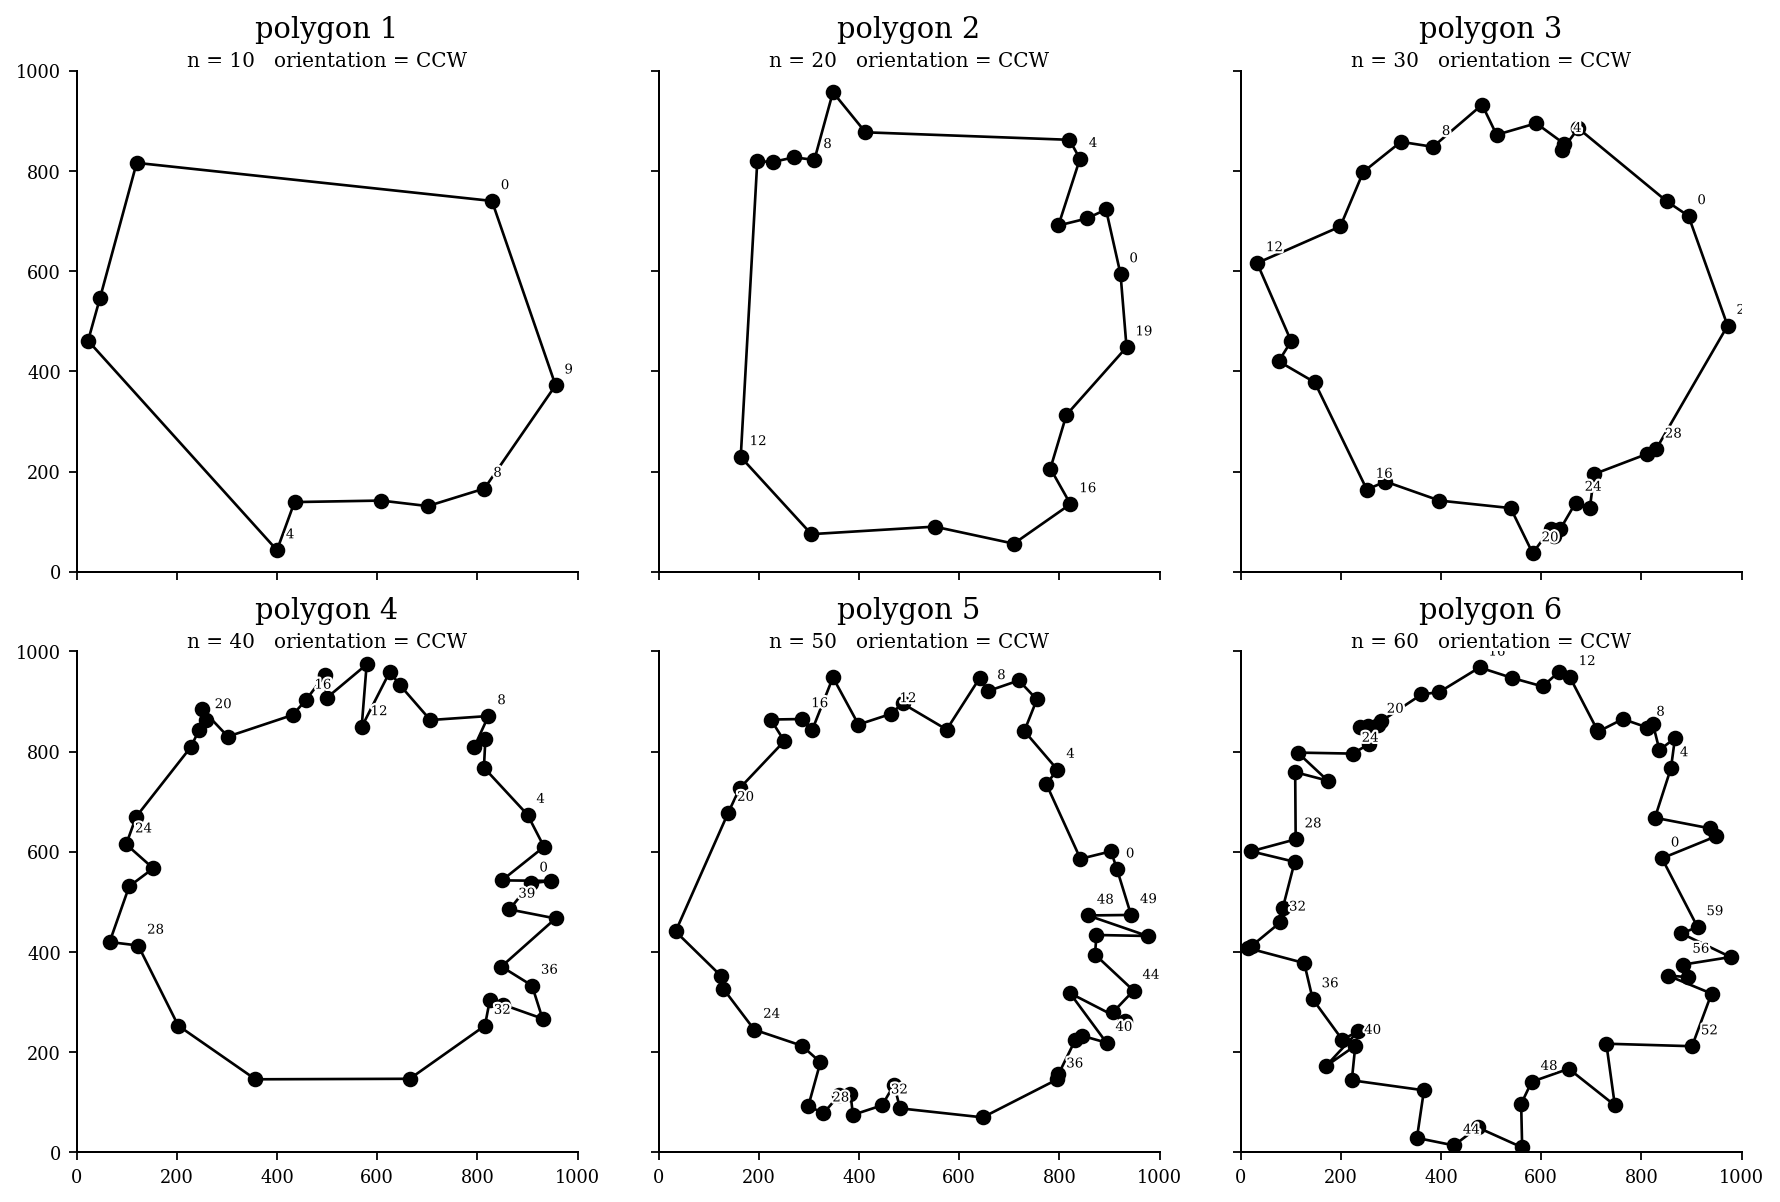

[init] n=10
[init] pts=[(829, 740), (120, 816), (47, 547), (23, 461), (400, 43), (435, 139), (608, 142), (701, 131), (814, 166), (956, 372)]
[seed-edge] p0=(829, 740), p1=(120, 816)  (seed base uses last collinear endpoint)
[seed-triple] p2=(47, 547), orient=196269 -> CCW
[D-init-CCW] D= [0:(47, 547) | 1:(829, 740) | 2:(120, 816) | 3:(47, 547)]

[scan] i=3, p=(23, 461)
[inside-test] left(top (120, 816)->(47, 547))=False, left(bot (47, 547)->(829, 740))=False
[pop-bot] removed=(47, 547); D=[0:(829, 740) | 1:(120, 816) | 2:(47, 547)]
[push-bot] insert (23, 461); D=[0:(23, 461) | 1:(829, 740) | 2:(120, 816) | 3:(47, 547)]
[pop-top] removed=(47, 547); D=[0:(23, 461) | 1:(829, 740) | 2:(120, 816)]
[push-top] append (23, 461); D=[0:(23, 461) | 1:(829, 740) | 2:(120, 816) | 3:(23, 461)]

[scan] i=4, p=(400, 43)
[inside-test] left(top (120, 816)->(23, 461))=True, left(bot (23, 461)->(829, 740))=False
[pop-bot] removed=(23, 461); D=[0:(829, 740) | 1:(120, 816) | 2:(23, 461)]
[push-bot] insert (

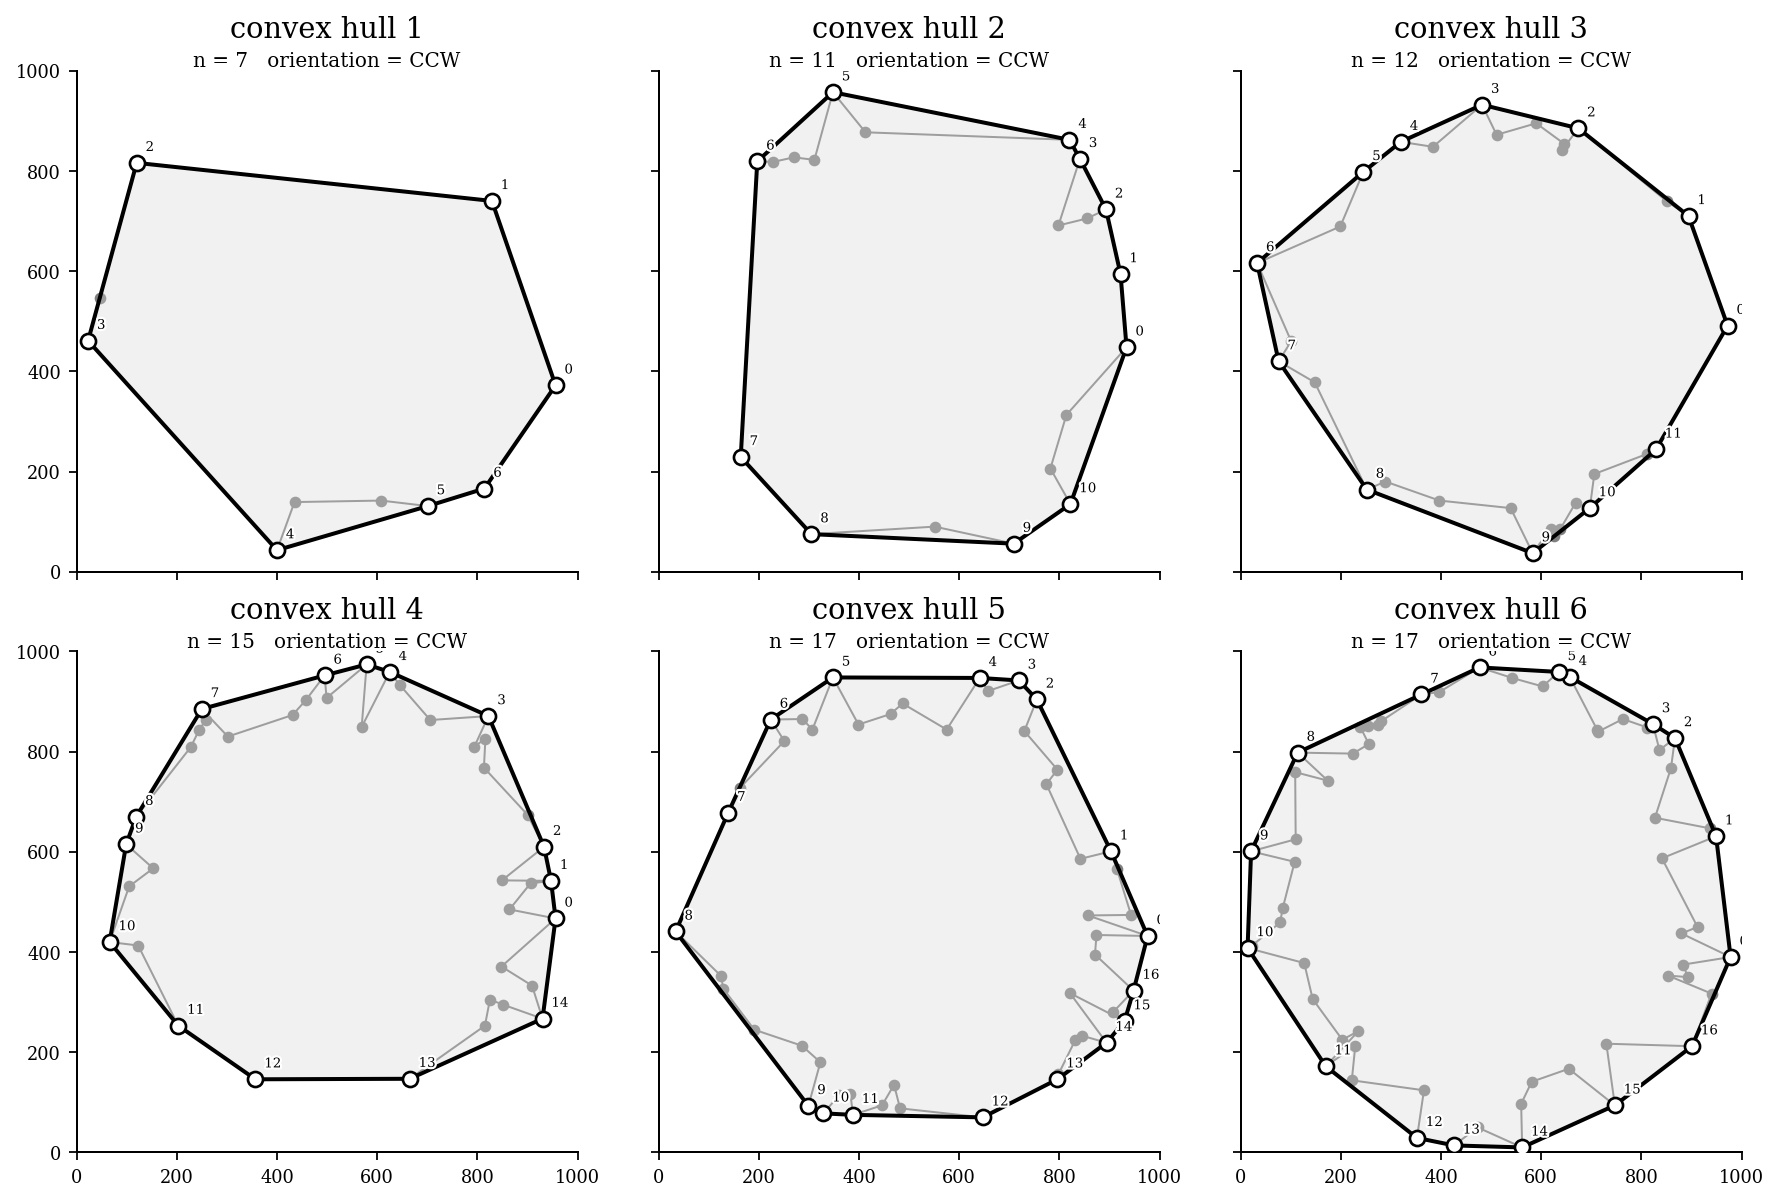

In [8]:
TestPolys = generate_ploys(
    sizes=[10, 20, 30, 40, 50, 60],
    image_size=1000,
    retries=500,
    seed=1024
)
TestPoly1, TestPoly2, TestPoly3, TestPoly4, TestPoly5, TestPoly6 = TestPolys

render_ploys(
    ploys = TestPolys,
    mark_every = 4,
    coord_range = 1000,
    cols_per_row = 3,
)

TestHull1 = melkman_convex_hull(TestPoly1)
TestHull2 = melkman_convex_hull(TestPoly2)
TestHull3 = melkman_convex_hull(TestPoly3)
TestHull4 = melkman_convex_hull(TestPoly4)
TestHull5 = melkman_convex_hull(TestPoly5)
TestHull6 = melkman_convex_hull(TestPoly6) 
TestHulls = [TestHull1, TestHull2, TestHull3, TestHull4, TestHull5, TestHull6]

render_hulls(
    hulls = TestHulls,
    polys = TestPolys,
    mark_every_poly = 0,
    mark_every_hull= 1,
    coord_range = 1000,
    cols_per_row = 3,
)

In [ ]:
stats = melkman_convex_hull(PolyA, test=True)

In [ ]:
cases = generate_complexity_cases("params.json")
P10, P100, P1000 = cases[10], cases[100], cases[1000]
complex_cases = [P10, P100, P1000]
render_triptych_from_polys(complex_cases)

NameError: name 'generate_complexity_cases' is not defined

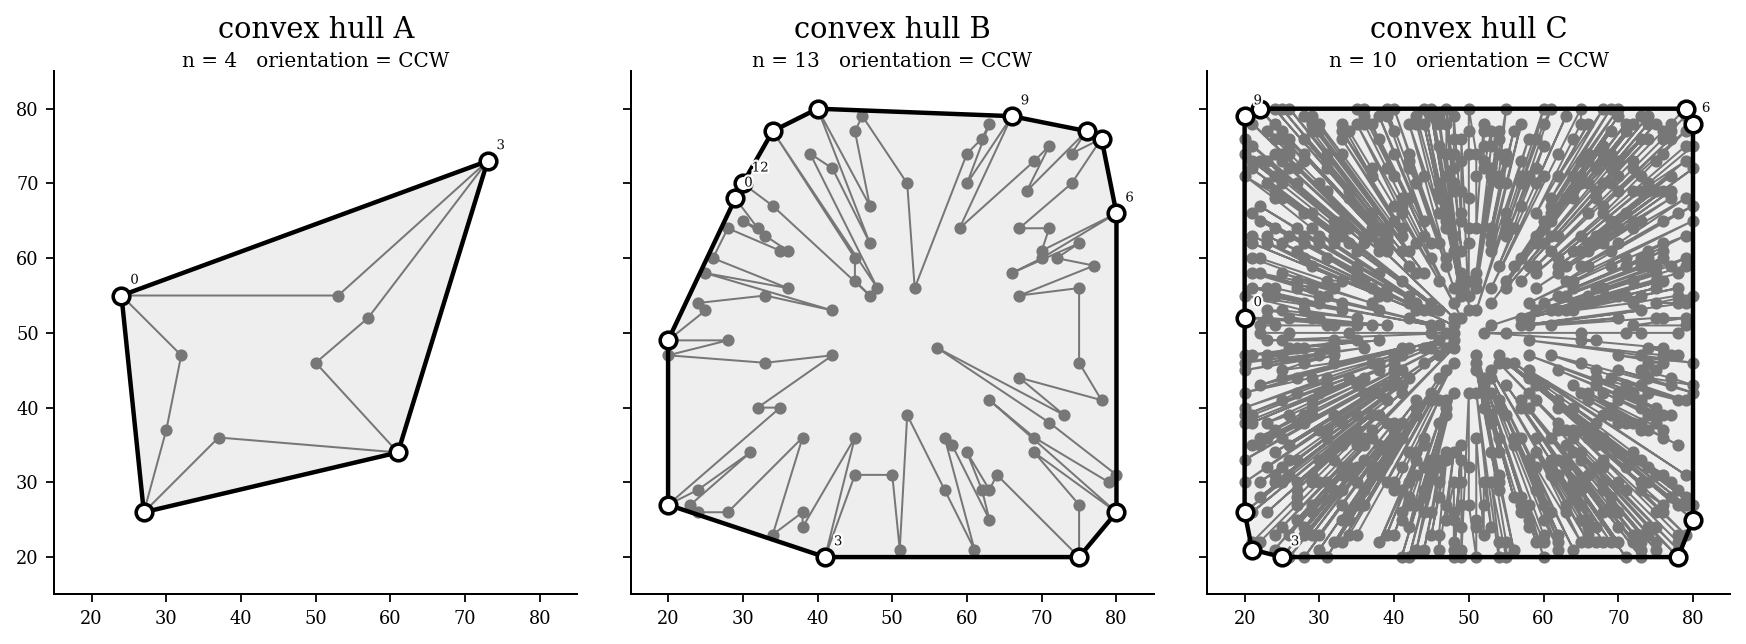

In [ ]:
cases = generate_complexity_cases("params.json")
P10, P100, P1000 = cases[10], cases[100], cases[1000]
HullP10 = melkman_convex_hull(P10)
HullP100 = melkman_convex_hull(P100)
HullP1000 = melkman_convex_hull(P1000)
complex_cases = [P10, P100, P1000]
Polys_and_Hulls = [(P10,HullP10), (P100,HullP100), (P1000,HullP1000)]
render_triptych_hulls(Polys_and_Hulls)

In [ ]:
stats10 = melkman_convex_hull(P10)
stats100 = melkman_convex_hull(P100)
stats1000 = melkman_convex_hull(P1000)
complex_stats = [stats10, stats100, stats1000]

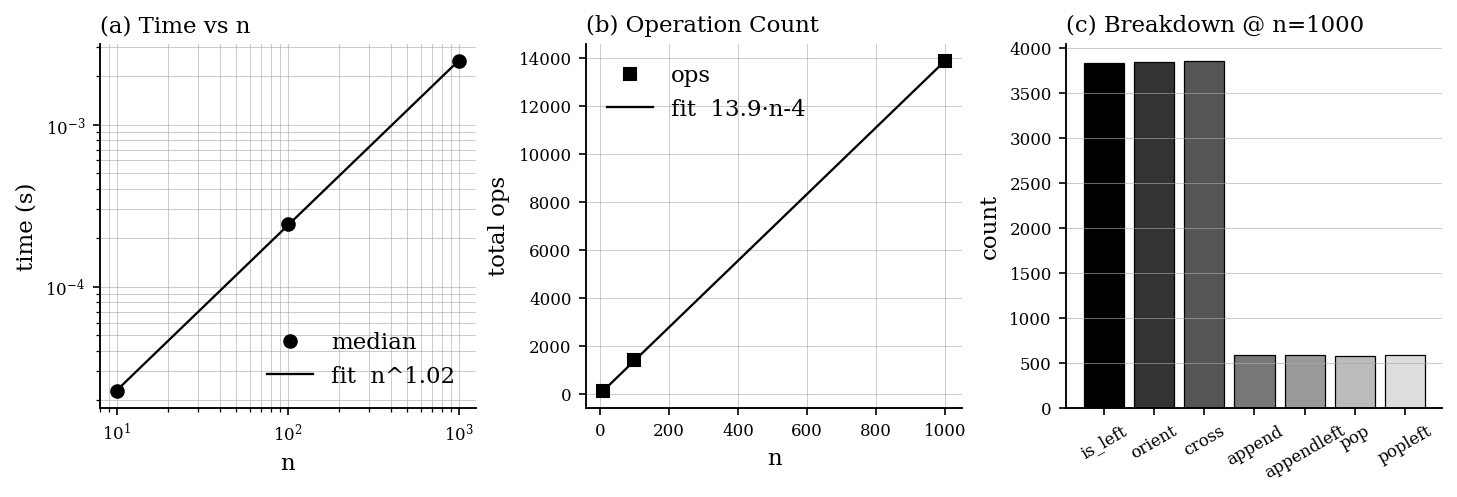

In [ ]:
report = analyze_melkman_complexity(complex_cases, complex_stats, melkman_convex_hull, runs=7, show=True)

In [ ]:
report

{'ns': [10, 100, 1000],
 'times': [2.1791987819597125e-05,
  0.00022045898367650807,
  0.002508125005988404],
 'ops': [114, 1407, 13876],
 'time_doubling': [10.117, 11.377],
 'ops_per_n': [11.4, 14.07, 13.876],
 'k_time': 1.0305261653132105,
 'a_ops': 13.882132132132131,
 'r2_time': 0.9993610102271611,
 'r2_ops': 0.9999917126402639,
 'breakdown_last': {'cross': 3853,
  'orient': 3843,
  'is_left': 3838,
  'append': 590,
  'appendleft': 586,
  'pop': 577,
  'popleft': 589,
  'while_top_iters': 589,
  'while_bot_iters': 576,
  'n': 1000,
  'hull_len': 10,
  'total_ops': 13876}}